# Topic Modelling

This Notebook does some data exploration on the SQL database containing twitter data. The goal is to use topic modelling methods to look for common patterns and topics in the data.


### References
https://github.com/derekgreene/topic-model-tutorial

In [1]:
# Let us import some of the twitter data into a padas notebook

import sqlite3
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

#conn = sqlite3.connect('location_based_database.db')
conn = sqlite3.connect('keyword_based_database.db')
#c = conn.cursor()
#c.execute('''SELECT * FROM tweet;''')

# Read into a Pandas Data Frame
df = pd.read_sql_query("SELECT * FROM tweet where tweet_text like '%BMW%' LIMIT 10000;",conn)
#df = pd.read_sql_query("SELECT * FROM tweet LIMIT 10000;",conn)

/home/javier/anaconda3/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/javier/anaconda3/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


DatabaseError: Execution failed on sql 'SELECT * FROM tweet where tweet_text like '%BMW%' LIMIT 10000;': no such table: tweet

In [2]:
# Some simple Data exploration

print('Column Names: ', list(df.columns.values),"\n")

print('The size of the table: ', len(df),'\n')

# Show the First ten items in the database
print(df['tweet_text'][0:10])


# Let us make a histogram of the 

NameError: name 'df' is not defined

In [70]:
# Sources: https://rustyonrampage.github.io/text-mining/2017/11/23/stemming-and-lemmatization-with-python-and-nltk.html


# Here we need to write a function that will clean up the tweet text:
# 1. Remove urls
# 2. Remove punctuation
# 3. 
import nltk
from textblob import TextBlob
from tqdm import tqdm
from collections import Counter 
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import sent_tokenize, word_tokenize
import re

# Only needed once
#nltk.download('punkt')
#nltk.download('wordnet')

ps = PorterStemmer()
wnl = WordNetLemmatizer()

def get_pos( word ):
    '''
    Part-Of-Speech Tagger
    '''
    w_synsets = wordnet.synsets(word)
    
    
    # n-noun, v-verb, a-adjective, r-
    pos_counts = Counter()
    pos_counts["n"] = len(  [ item for item in w_synsets if item.pos()=="n"]  )
    pos_counts["v"] = len(  [ item for item in w_synsets if item.pos()=="v"]  )
    pos_counts["a"] = len(  [ item for item in w_synsets if item.pos()=="a"]  )
    pos_counts["r"] = len(  [ item for item in w_synsets if item.pos()=="r"]  )
    
    most_common_pos_list = pos_counts.most_common(3)
    return most_common_pos_list[0][0]

def clean_up_tweet(text):
    # Remove @ from the string
    s=re.sub(r'@[A-Za-z0-9]+','',text)    
    
    # Remove URLS
    s=re.sub('https?://[A-Za-z0-9./]+','',s)
    
    # Set to lower case
    s=s.lower()
    
    # Remove numbers
    s= re.sub(r'[0-9]+', '', s) 
    
    # Remove punctuation
    s = re.sub(r'[^\w\s]','',s)
    
    # Remove underscore
    s=s.replace("_", " ")
    
    # Remove RT from the tweet
    s=s.replace("rt", "")
    
    # Tokenize the words
    words = word_tokenize(s)
    
    # Lemmatize the words
    s_stem = ''
    for wi in words:
        #wi = ps.stem(wi)
        wi = wnl.lemmatize(wi,get_pos(wi))
        s_stem += ' ' + wi
    
    return s_stem

text = df['tweet_text'][6]

print("Example: ", text,'\n')
print("Cleaned up:",clean_up_tweet(text))


df['tweet_text'] = df['tweet_text'].apply(clean_up_tweet)

print('The size of the table: ', len(df),'\n')


# Remove duplicate tweets and reset the index
df.drop_duplicates(subset='tweet_text', keep='first', inplace=True)
df=df.reset_index(drop=True)
print('The size of the table: ', len(df),'\n')

Example:  RT @NicoTeboho: For the love of BMW M8 ❤️❤️❤️ https://t.co/8FMN5sd8Pz 

Cleaned up:  for the love of bmw m
The size of the table:  10000 

The size of the table:  4210 



In [71]:
import os.path
raw_documents = []
snippets = []

for k in range(0,len(df)):
    text = df['tweet_text'][k]
    raw_documents.append(text)
    snippets.append(text)
    #snippets.append( text[0:min(len(text),100)])

print("Read %d raw text documents" % len(raw_documents))

Read 4210 raw text documents


In [72]:
# Now we need to create the document term matrix
from sklearn.feature_extraction.text import CountVectorizer

# We will load in the custom stop words
custom_stop_words = []
with open( "stopwords.txt", "r" ) as fin:
    for line in fin.readlines():
        custom_stop_words.append( line.strip() )

# note that we need to make it hashable
print("Stopword list has %d entries" % len(custom_stop_words) )

# use a custom stopwords list, set the minimum term-document frequency to 20
vectorizer = CountVectorizer(stop_words = custom_stop_words, min_df = 20)
A = vectorizer.fit_transform(raw_documents)
print( "Created %d X %d document-term matrix" % (A.shape[0], A.shape[1]) )

Stopword list has 355 entries
Created 4210 X 257 document-term matrix


In [73]:
from sklearn.externals import joblib

# We print out the number of features in the vocabulary
terms = vectorizer.get_feature_names()
print("Vocabulary has %d distinct terms" % len(terms))

# Save the vocabulary to a file
joblib.dump((A,terms,snippets), "articles-raw.pkl") 

Vocabulary has 257 distinct terms


['articles-raw.pkl']

In [74]:
from sklearn.feature_extraction.text import TfidfVectorizer


# we can pass in the same preprocessing parameters
vectorizer = TfidfVectorizer(stop_words=custom_stop_words, min_df = 20)
A = vectorizer.fit_transform(raw_documents)
print( "Created %d X %d TF-IDF-normalized document-term matrix" % (A.shape[0], A.shape[1]) )

# extract the resulting vocabulary
terms = vectorizer.get_feature_names()
print("Vocabulary has %d distinct terms" % len(terms))

Created 4210 X 257 TF-IDF-normalized document-term matrix
Vocabulary has 257 distinct terms


In [75]:
import operator
def rank_terms( A, terms ):
    # get the sums over each column
    sums = A.sum(axis=0)
    # map weights to the terms
    weights = {}
    for col, term in enumerate(terms):
        weights[term] = sums[0,col]
    # rank the terms by their weight over all documents
    return sorted(weights.items(), key=operator.itemgetter(1), reverse=True)

ranking = rank_terms( A, terms )
for i, pair in enumerate( ranking[0:20] ):
    print( "%02d. %s (%.2f)" % ( i+1, pair[0], pair[1] ) )
    
# Save these terms for later use    
joblib.dump((A,terms,snippets), "articles-tfidf.pkl") 

01. bmw (827.00)
02. car (185.12)
03. series (159.08)
04. drive (111.53)
05. get (99.96)
06. video (92.66)
07. sale (70.54)
08. buy (69.07)
09. look (63.20)
10. amp (55.85)
11. take (54.51)
12. bmws (54.45)
13. competition (54.18)
14. mercedes (51.29)
15. coupe (50.00)
16. driver (49.97)
17. see (48.16)
18. model (45.39)
19. time (44.94)
20. engine (43.40)


['articles-tfidf.pkl']

# Matrix Factorization

Here we factorize the Document matrix $A$ into the form,

$A = W H$,

where $W$ is the (vector(Document), topic) matrix and $H$ is the (topic, Document) matrix.

Loaded 4210 X 257 document-term matrix
3 1.08847395576
4 0.248765558895
5 0.267242439982
6 0.17905317132
7 0.155543055545
8 0.129734962964
9 0.0577517615224
10 0.104534065974
11 0.121958134235
12 0.0221691418737
13 0.0571729929883
14 0.100326775417
15 -0.00608189962759


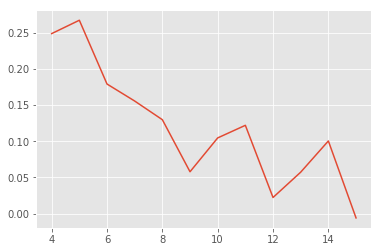

In [76]:
# We load the document term matrix
from sklearn import decomposition
from sklearn.externals import joblib
import scipy as sc

# Load in the Data
(A,terms,snippets) = joblib.load( "articles-tfidf.pkl" )
print( "Loaded %d X %d document-term matrix" % (A.shape[0], A.shape[1]) )


def compute_entropy(N_vec):
    N = float(np.sum(N_vec))
    p_data = N_vec/N
    Es=sc.stats.entropy(p_data)
    return Es

# The threshold for the sorting
threshold = 0.6

kmin,kmax = 3,15

Es_vec = []
k_vec = []

Esm1 = 0.0
for k in range(kmin,kmax+1):
    # create the model
    #k = 10 # The number of topics to generate

    # There are two available decompositions available:
    #model = decomposition.NMF( init="nndsvd", n_components=k ) 
    model = decomposition.LatentDirichletAllocation(n_components=k, max_iter=5, learning_method='online', learning_offset=50.,random_state=0)

    # apply the model and extract the two factor matrices
    W = model.fit_transform( A )
    H = model.components_
    
    N_topic_samples = []

    for topic in range(0,k):
        above_threshold = len(W[W[:,topic]>=threshold,topic])
        N_topic_samples.append(above_threshold)
    
    N_topic_samples = np.asarray(N_topic_samples)
    Es= compute_entropy(N_topic_samples)
    print(k,Es-Esm1)
    Es_vec.append(Es-Esm1)
    k_vec.append(k)
    
    Esm1 = Es

plt.plot(k_vec[1:],Es_vec[1:])
plt.show()

In [83]:
# Choose the optimal numberof topics
k = 9
model = decomposition.LatentDirichletAllocation(n_components=k, max_iter=5, learning_method='online', learning_offset=50.,random_state=0)

# apply the model and extract the two factor matrices
W = model.fit_transform( A )
H = model.components_

(4210, 9)
0.745524243262
0.0253374832038
Topic:  1
Number of Tweets above the threshold:  94
Topic:  2
Number of Tweets above the threshold:  200
Topic:  3
Number of Tweets above the threshold:  115
Topic:  4
Number of Tweets above the threshold:  69
Topic:  5
Number of Tweets above the threshold:  105
Topic:  6
Number of Tweets above the threshold:  83
Topic:  7
Number of Tweets above the threshold:  194
Topic:  8
Number of Tweets above the threshold:  125
Topic:  9
Number of Tweets above the threshold:  74


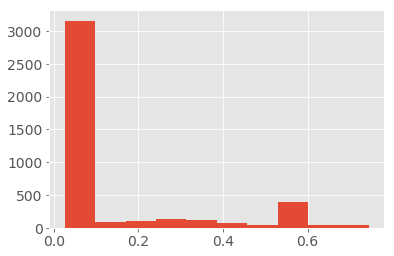

In [84]:
# The W[i][j] matrix, i represents the document, and j represents the association with a given topic
print(W.shape)

topic = 0
print(max(W[:,topic]))
print(min(W[:,topic]))
plt.hist(W[:,topic])

N_topic_samples = []

for topic in range(0,k):
    above_threshold = len(W[W[:,topic]>=threshold,topic])
    print('=========================================================')
    N_topic_samples.append(above_threshold)
    print('Topic: ', topic+1)
    print( "Number of Tweets above the threshold: ", above_threshold )
    print('=========================================================')

In [85]:

def get_descriptor( terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
    return top_terms


descriptors = []
word_dict = {}

for topic_index in range(k):
    descriptors.append( get_descriptor( terms, H, topic_index, 20 ) )
    str_descriptor = ", ".join( descriptors[topic_index] )
    word_dict['Topic # ' + '{:02d}'.format(topic_index+1)] = [word for word in descriptors[topic_index]];

# Data Frame with Topic words
pd.DataFrame(word_dict)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09
0,bmw,bmw,buy,review,driver,bmw,video,sale,series
1,coupe,car,bmw,bmw,bmw,im,bmw,bmw,look
2,mile,drive,need,right,uk,want,competition,time,take
3,spo,bmws,good,roadster,fit,police,get,mercedes,bmw
4,series,check,call,black,mi,motorcycle,wheel,fire,sa
5,conveible,profit,bmwm,man,oem,luxury,honda,audi,price
6,xdrive,ebay,back,team,win,go,tesla,vehicle,love
7,service,group,know,head,work,see,pa,brand,allnew
8,test,mini,model,road,front,way,race,amp,launch
9,available,gt,think,try,leave,motorrad,day,korea,engine


In [94]:
# Analysis using textblob
from textblob import TextBlob
import collections

plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

def plot_top_term_weights( terms, H, topic_index, top ):
    # get the top terms and their weights
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    top_terms = []
    top_weights = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
        top_weights.append( H[topic_index,term_index] )
    # note we reverse the ordering for the plot
    top_terms.reverse()
    top_weights.reverse()
    # create the plot
    fig = plt.figure(figsize=(13,8))
    # add the horizontal bar chart
    ypos = np.arange(top)
    ax = plt.barh(ypos, top_weights, align="center", color="green",tick_label=top_terms)
    plt.xlabel("Term Weight",fontsize=14)
    plt.tight_layout()
    plt.show()
    
    
#plot_top_term_weights( terms, H, topic, 10 )    


# Let us look now at the most relevant posts for each topic

def get_top_snippets( all_snippets, W, topic_index, top ):
    
    # reverse sort the values to sort the indices
    top_indices = np.argsort( W[:,topic_index] )[::-1]
    
    # now get the snippets corresponding to the top-ranked indices
    top_snippets = []
    for doc_index in top_indices[0:top]:
        top_snippets.append( all_snippets[doc_index] )
    return top_snippets

topic = 5
topic_snippets = get_top_snippets( snippets, W, topic, 10 )

print('================================================')
print('\n Topic: ', topic+1)
for i, snippet in enumerate(topic_snippets):
    print("%02d. %s " % ( (i+1), snippet) )
print('================================================\n')    




 Topic:  6
01.  pull up to my house amp i see a bmw park in front of my drive way tell me why i think it be my ex boyfri 
02.  when you think you could go to a dealer to buy a bmw but youre now ready to take a mitsubishi galant it will 
03.  the way i see it be i get something fast than a k bmw m for k 
04.  help retweet till we find the owner of the bmw car the murderer and the police must be apprehend this be so sad we l 
05.  help retweet till we find the owner of the bmw car the murderer and the police must be apprehend this be so sad 
06.  im so sure d owner of that bmw be a police officer 
07.  underrate character be it bad that i really want to buy a bmw motorcycle after this movie 
08.  i get to touch the bmw m use in the begin of the movie hnnnnnn i want to take the car home 
09.  my nigga fernando that get black beemer i wan na bmw luxury too 
10.  tottenham be the so of guy who drive a bmw but only want to spend p in poundland 



In [87]:
def calculate(topic,dN_sentiment):
    
    N=[]
    percent_negative = []
    percent_positive = []
    percent_neutral = []
    
    for N_sentiment in range(10,N_topic_samples[topic]+1,dN_sentiment):
        sentiment_polarity_data= []
        sentiment_subjectivity_data= []
    
    
        # Get the top N_sentiment snippets  
        topic_snippets = get_top_snippets( snippets, W, topic, N_sentiment )

        # Calculate the sentiment of the top N_sentiment 
        for i, snippet in enumerate(topic_snippets):
            snippet_polarity_score =  TextBlob(snippet).sentiment.polarity # Polarity, [1]= subjectivity
            snippet_subjectivity_score = TextBlob(snippet).sentiment.subjectivity

            if(snippet_polarity_score>=0.5):
                sentiment_polarity_data.append(1.0)
            elif(snippet_polarity_score<=-0.5):
                sentiment_polarity_data.append(-1.0)
            else:
                sentiment_polarity_data.append(0.0)

        sentiment_polarity_data = np.asarray(sentiment_polarity_data)
        sentiment_subjectivity_data = np.asarray(sentiment_subjectivity_data)

        # Collect all results 
        pos = collections.Counter(sentiment_polarity_data)[1]/len(sentiment_polarity_data)*100.0
        neg = collections.Counter(sentiment_polarity_data)[-1]/len(sentiment_polarity_data)*100.0
        neut =  collections.Counter(sentiment_polarity_data)[0]/len(sentiment_polarity_data)*100.0
        N.append(N_sentiment)

        percent_negative.append(neg)
        percent_positive.append(pos)
        percent_neutral.append(neut)
    
    return N,percent_negative, percent_positive, percent_neutral

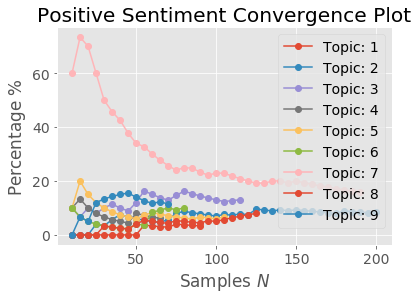

<Figure size 432x288 with 0 Axes>

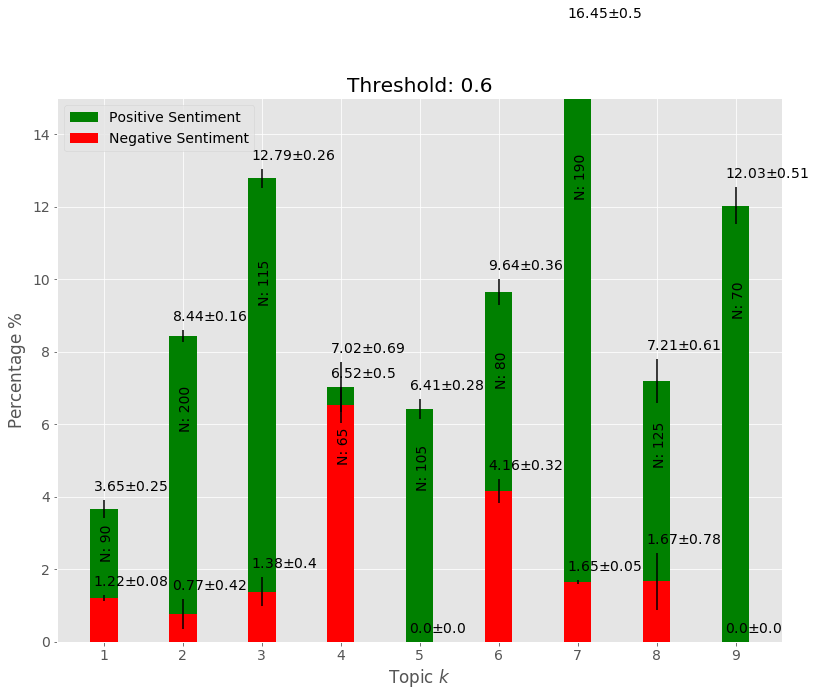

In [88]:
# Calculate the sentiments for all topics
dN_sentiment = 5 
uncert_samples = 4

topic_pos = np.zeros(k)
sigma_topic_pos = np.zeros(k)

topic_neg = np.zeros(k)
sigma_topic_neg = np.zeros(k)

topic_neutral = np.zeros(k)
sigma_topic_neutral = np.zeros(k)

topic_N = np.zeros(k)

plt.clf()
for topic in range(k):
    
    N,percent_negative, percent_positive, percent_neutral = calculate(topic,dN_sentiment)   
    
    topic_pos[topic] =  np.mean(percent_positive[-uncert_samples:])
    sigma_topic_pos[topic] = np.std(percent_positive[-uncert_samples:])
    
    topic_neg[topic] =  np.mean(percent_negative[-uncert_samples:])
    sigma_topic_neg[topic] = np.std(percent_negative[-uncert_samples:])
    
    topic_neutral[topic] = np.mean(percent_neutral[-uncert_samples:])
    sigma_topic_neutral[topic] = np.std(percent_neutral[-uncert_samples:])
    
    topic_N[topic] = N[-1]
    plt.plot(N,percent_positive,'-o',label='Topic: '+str(topic+1))

plt.legend()
plt.title("Positive Sentiment Convergence Plot")
plt.ylabel("Percentage $\%$")
plt.xlabel("Samples $N$")
plt.show()     


# Width of the Bar plots
width=0.35

# Text on the top of each barplot
x_axis_num = range(0,k)
x_axis_label = [str(i+1) for i in x_axis_num]
    
plt.clf()
plt.figure(figsize=(13,10))
plt.xticks(x_axis_num, x_axis_label)
plt.bar(x_axis_num, topic_pos,width,yerr=sigma_topic_pos,label="Positive Sentiment",color='g')
plt.bar(x_axis_num, topic_neg, width,yerr=sigma_topic_neg, label="Negative Sentiment",color='r')


for i in range(0,k):
    plt.text(i-0.13,y=topic_pos[i]+0.25+sigma_topic_pos[i],s=str(round(topic_pos[i],2))+'$\pm$'+str(round(sigma_topic_pos[i],2)))
    plt.text(i-0.13,y=topic_neg[i]+0.25+sigma_topic_neg[i],s=str(round(topic_neg[i],2))+'$\pm$'+str(round(sigma_topic_neg[i],2)))
    plt.text(i-0.05,y=0.8*topic_pos[i],s='N: '+str(int(topic_N[i])),rotation=90.0)

plt.ylim(0.0,15.0)
plt.ylabel("Percentage $\%$")
plt.xlabel("Topic $k$")
plt.title("Threshold: " + str(threshold))
plt.legend()
plt.show()

